In [1]:
import importlib
import os
import re
import pandas as pd
from MARM.paths import get_figure_dir
from MARM.pysb_flat.RTKERK__base__EGF_EGFR_MEKi_PRAFi_RAFi__channel_monoobs import model
import pysb
from pysb.pattern import SpeciesPatternMatcher
from pysb.bng import generate_equations
from collections import Counter

In [2]:
generate_equations(model)

In [3]:
spm = SpeciesPatternMatcher(model)

channel_species = set(
    spm.match(model.components['MEK'](channel='onco'), index=True)   
    + spm.match(model.components['MEK'](channel='phys'), index=True)
    + spm.match(model.components['ERK'](channel='phys'), index=True)
    + spm.match(model.components['ERK'](channel='onco'), index=True)
)

In [4]:
reactions = [r for r in model.reactions 
             if any(ix in channel_species for ix in list(r['reactants']) + list(r['products'])) 
             and not r['rule'][0].startswith('pERK_phosphorylates') 
             and not r['rule'][0].startswith('ERK_synthesizes')]
reaction_rules = Counter(r['rule'][0] for r in reactions)
counts = pd.DataFrame(reaction_rules, index=[0])

summarize_cols = {
    'BRAFV600E_phosphorylates_MEK': [col for col in counts.columns 
                                     if col.startswith('BRAFV600E_phosphorylates_MEK')],
    'RAFRAF_phosphorylates_MEK': [col for col in counts.columns
                                  if re.match('[BC]+RAF_[BC]+RAF_phosphorylates_MEK', col)]
}

for col in counts.columns:
    if col.endswith('_onco'):
        summarize_cols[col.replace('_onco', '')] = [col, col.replace('_onco','_phys')]

for group, cols in summarize_cols.items():
    counts[group] = counts[cols].sum(axis=1)
    counts.drop(columns=cols, inplace=True)

In [5]:
initiation = ['BRAFV600E_phosphorylates_MEK', 'RAFRAF_phosphorylates_MEK']
propagation = ['pMEK_phosphorylates_ERK']
termination = ['MEK_is_dephosphorylated', 'DUSP_dephosphorylates_ERK']
sorted_cols = initiation + propagation + termination
counts = counts[sorted_cols + [col for col in counts.columns if col not in sorted_cols]]

In [6]:
df = pd.melt(counts)

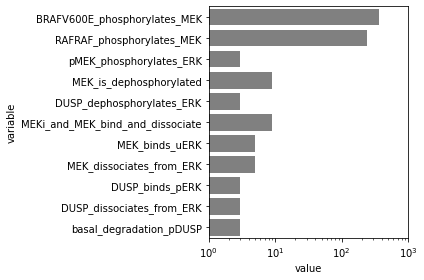

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl


ax = sns.barplot(x="value", y="variable", data=pd.melt(counts), color='gray', left=1)
plt.xscale('log')
plt.xlim((1e0,1e3))
plt.tight_layout()

plt.savefig(os.path.join(get_figure_dir('RTKERK', 'base', 'EGF_EGFR_MEKi_PRAFi_RAFi'), 'model_channel_decomposition.pdf'))